## t-SNE

This notebook implements the t-SNE mapping for visualising higher dimensional datasets into lower dimensions.

### Importing the Libraries

In [212]:
# import libraries 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Dimensionality Reduction

Reducing the higher dimensional data to 30 major components using the PCA decomposition.

In [213]:

def reduceDimensionality(data, n_components = 30):
    
    """
    This function aims to reduce the higher dimensional data to lower dimensions [ = 30 ]
    
    Parameters
    ----------
    data : data frame object with last column being the label corresponding to the given data samples
    n_components : number of components to be reduced to

    """
    # standardize the data
    scaler = StandardScaler()
    x = data[:,:-1]
    y = data[:,-1]
    x = scaler.fit_transform(x)
    # apply PCA
    pca = PCA(n_components = n_components)
    x = pca.fit_transform(x)
    # concatenate the data
    data = np.concatenate((x, y.reshape(-1,1)), axis = 1)
    return data


In [214]:
def plotPCA(data,title):

    """
    Function to plot the generated PCA plot , only in 2 dimensions considering the major 2 PCA components 
    
    Parameters:
    -----------
    data : data frame object with last column being the label corresponding to the given data samples
    title : title of the plot
    
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5,c=data[:,-1])
    plt.colorbar()
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(title)
    plt.show()

# Probability Matrice Q in the lower dimensional space

Calculating the similarity matrix, amongst the points in the lower dimensions. Wherein each element in the matrix is given by : 

$ q_{i, j} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\Sigma_{k\neq l}(1+||y_k-y_l||^2)^{-1}} $

In [235]:
def computePairwiseDistances(X):
    """
    Function to compute the pairwise distances between the data points in the higher dimensional space
    
    Parameters: 
    -----------
    X : data points in the higher dimensional space

    """
    cummulative_sum  = np.sum(np.square(X), axis=1)
    pairwise_distance = np.add(np.add(-2 * np.dot(X, X.T), cummulative_sum).T, cummulative_sum)
    return -pairwise_distance

def computeQMatrix(Y):
    """
    Function to compute the Q matrix for the given data points
    
    Parameters: 
    -----------

    Y : data points in the lower dimensional space

    """
    pairwise_distances=computePairwiseDistances(Y)
    pairwise_distances=1. - pairwise_distances
    inverse_distances=np.power(pairwise_distances,-1)
    np.fill_diagonal(inverse_distances,0.)
    return inverse_distances/np.sum(inverse_distances), inverse_distances

## Binary Search and Probobility matrix functions


In [217]:
# code 
def computeProbMatrix(pairwise_dist,sigmas,index=None):
    """
    Function to compute the probability matrix for the given data points
    
    Parameters: 
    -----------

    Y : data points in the lower dimensional space

    """
    pairwise_dist=np.array(pairwise_dist)
    if sigmas is None:
        e_x = np.exp(pairwise_dist - np.max(pairwise_dist, axis=1).reshape([-1, 1]))
    else:
        sigmas=np.array(sigmas)
        sigmas=sigmas.reshape(1,-1)
        sigma_square = 2.*np.square(sigmas.T)
        e_x = np.exp(pairwise_dist/sigma_square - np.max(pairwise_dist/sigma_square, axis=1).reshape([-1, 1]))

    if index is None:
        np.fill_diagonal(e_x, 0.)
    else:
        e_x[:, index] = 0.
    e_x = e_x + 1e-8
    sigmas =  e_x / e_x.sum(axis=1).reshape([-1, 1])
    return sigmas

def BinarySearch(comparator, target):
    """
    Function to perform binary search on the given comparator function
    
    Parameters: 
    -----------
    comparator : comparator function
    target : target value to be searched for

    """
    lower_bound=1e-18
    upper_bound=1000
    iterations=0
    sensitivity=1e-10
    mid=(upper_bound+lower_bound)/2
    while np.abs(comparator(mid)-target)>sensitivity:
        mid=(upper_bound-lower_bound)/2
        if comparator(mid)>target:
            upper_bound=mid
        else:
            lower_bound=mid
        iterations=iterations+1
        if(iterations==10000):
            break
    return mid


## Calculating the optimal variances using perplexity

- Perplexity is defined as 
    $$
    Perp(P_i) = 2^{H(P_i)}
    $$
    Where $H$ is the shanon's entropy.

- Shanon's entropy is defined as:
    $$
    H(P_i) = - \sum_i  p_{j|i} \log(p_{j|i})
    $$

In [218]:
def computePerplexity(pairwise_dist, sigmas,index=None):
    """
    Function to compute the perplexity for the pairwise distances

    Parameters:
    -----------
    pairwise_dist : pairwise distances between the data points
    sigmas : sigmas corresponding to the data points
    """
    # compute the probability matrix
    prob_matrix = computeProbMatrix(pairwise_dist,sigmas,index=index)
    # compute the entropy
    H = np.sum(prob_matrix * np.log2(prob_matrix + 1e-12), axis=1)
    # compute the perplexity
    perplexity = 2**(-H)
    return perplexity

def computeOptimalVariances(pairwise_dist, perplexity):
    """
    Function to compute the optimal variances for the given perplexity
    
    Parameters: 
    -----------
    pairwise_dist : pairwise distances between the data points
    perplexity : perplexity corresponding to the data points

    """
    # compute the optimal variances
    sigmas = np.zeros((pairwise_dist.shape[0]))
    for i in range(pairwise_dist.shape[0]):
        comparator = lambda sigma: computePerplexity(pairwise_dist[i:i+1,:], np.array(sigma),i)
        sigmas[i] = BinarySearch(comparator, perplexity)
    return sigmas

## Computing pairwise affinities according to the best value of variances

The pairwise affinities are defines as the conditional probability $P_{j|i}$:
$$
p_{j|i} = \frac{exp\left({\frac{-||x_i - x_j||^2}{2\sigma_i^2}}\right)}{\sum_{k\ne i }exp\left({\frac{-||x_i - x_k||^2}{2\sigma_i^2}}\right)}
$$

We then set the joint probabilityies $p_{ij}$ in the high-dimensional space to be the symmetrized conditional probabilities:
$$
p_{ij} = \frac{p_{i|j} + p_{j|i}}{2n}
$$

In [219]:
def computeJointProbabilities(X, perplexity):
    """
    Function to compute the joint probabilities for the given data points
    
    Parameters: 
    -----------
    X : data points in the higher dimensional space
    perplexity : perplexity corresponding to the data points

    """
    # compute the pairwise distances and optimal variances
    pairwise_dist = computePairwiseDistances(X)
    sigmas = computeOptimalVariances(pairwise_dist, perplexity)

    # compute the pairwise affinities
    pairwise_affinities = computeProbMatrix(pairwise_dist, sigmas)
    
    # compute the joint probabilities
    joint_probabilities = (pairwise_affinities + pairwise_affinities.T) / (2 * X.shape[0])

    return joint_probabilities

# Gradient Descent

The gradient of the t-SNE cost function reduces to a simple form : 

$ \frac{\partial C}{\partial y_i} = 4\Sigma_{j} (p_{i, j} - q_{i, j})(y_i - y_j)(1 + ||y_i-y_j||^2)^{-1}$, 

In [220]:
def objectiveFunction(Y,P,Q,inv_distances):
    """
    Function to calculate the main objective function of t-SNE
    Parameters:
    -----------
    Y : The data points in the lower dimensional space
    P : The joint probability distribution of the data points in the high dimensional space
    Q : The joint probability distribution of the data points in the low dimensional space
   
    """
    # difference is a nxn matrix
    difference = P - Q
    pq_expanded = np.expand_dims(difference, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(inv_distances, 2)
    y_diffs_wt = y_diffs * distances_expanded
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    print("GRAD SHAPE :",grad.shape)
    return grad

    



In [221]:
def gradientDescent(Y,P,learningRate= 200.0 , momentum = 0.9, maxIterations = 500):
   
    """
    Performs the gradient descent step for t-SNE algorithm 

    Parameters:
    -----------
    
    learningRate : learning rate for the gradient descent step

    momentum : momentum for the gradient descent step

    maxIterations : maximum number of iterations for the gradient descent step
    
    """

    # store the variation of the points in gradient descent steps
    Y_iterations = []

    Y_t1 = Y.copy()
    Y_t2 = Y.copy()
    for iteration in range(0,maxIterations):


        Y_iterations.append(Y.copy().reshape(-1,2))
        # the similarity matrix in the low dimensional space
        Q,inv_distances = computeQMatrix(Y)
        
        # gradient is a 1-D array consisting of point-wise gradients 
        gradient = objectiveFunction(Y,P,Q,inv_distances)

        modGradient = np.linalg.norm(gradient)

        # update the points in the low dimensional space
        Y = Y - learningRate * gradient + momentum * (Y_t1 - Y_t2) 
        # update the vector terms
        Y_t2 = Y_t1.copy()
        Y_t1 = Y.copy()
    
    return Y, np.array(Y_iterations)

## Load MNIST Dataset

- Loading the mnist dataset and reducing it to a lower dimensional space using PCA and number of components as 30

In [222]:
import seaborn as sns
from scipy.linalg import eigh

In [223]:
df = pd.read_csv('./data/mnist_train.csv')
print(df.shape)
df.head()

(60000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
labels = df['label']
data = df.drop('label', axis = 1)
data = data.values
data = np.concatenate((data, labels.values.reshape(-1,1)), axis = 1)
data = reduceDimensionality(data)
data.shape

(60000, 31)

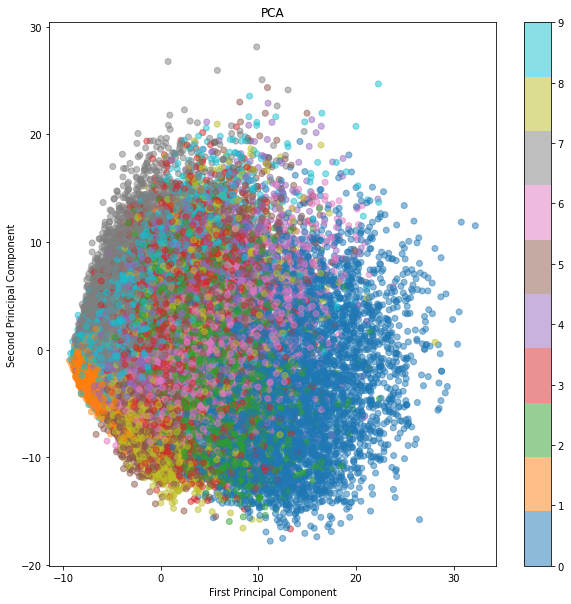

In [225]:
#  plot PCA
plotPCA(data, 'PCA')

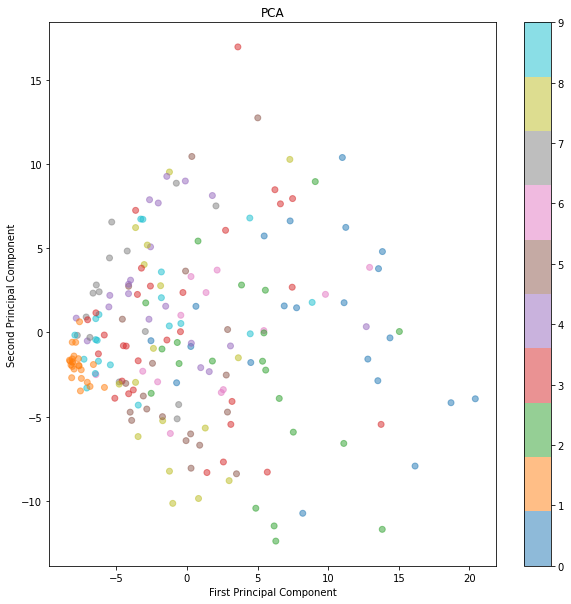

In [226]:
# get random 200 points
indices = np.random.choice(data.shape[0], 200, replace = False)
data = data[indices, :]
plotPCA(data, 'PCA')

In [227]:
X = data[:, :-1]
y = data[:, -1]
Y = np.random.randn(X.shape[0], 2)
P = computeJointProbabilities(X, 20)


In [228]:
Y_pred , Y_iterations = gradientDescent(Y,P)
import pickle
with open('Y_iterations.pkl', 'wb') as f:
    pickle.dump(Y_iterations, f)

with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE : (200, 2)
GRAD SHAPE

In [229]:
print(Y_pred.shape)

(200, 2)


In [230]:
import matplotlib as mpl
plt.rcParams['image.cmap'] = 'tab10'

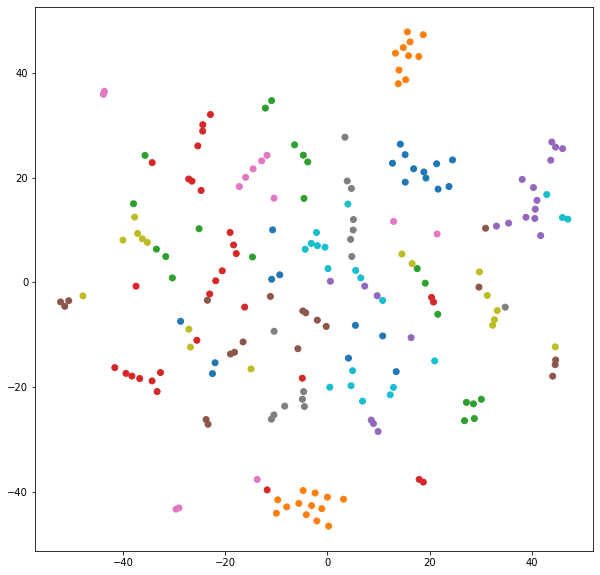

In [231]:
# import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(Y_pred[:,0],Y_pred[:,1],c=y)

# plt.scatter(Y_pred[:,0], Y_pred[:,1], c = y, cmap = 'jet')
# plt.colorbar()
plt.show()

## Ove

In [232]:
# import oliveetti
from sklearn import datasets
datasetoli = datasets.fetch_olivetti_faces()
X = datasetoli["data"]
y = datasetoli["target"]

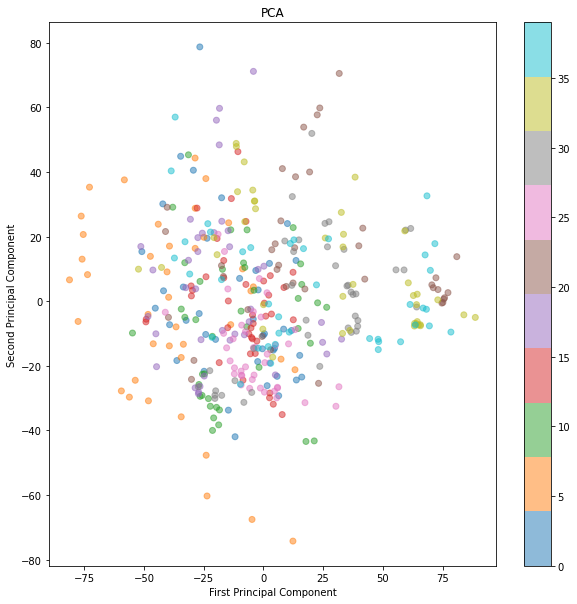

In [233]:
data = np.concatenate((X, y.reshape(-1,1)), axis = 1)
data = reduceDimensionality(data)
plotPCA(data, 'PCA')

In [ ]:
X = data[:, :-1]
y = data[:, -1]
Y = np.random.randn(X.shape[0], 2)
P = computeJointProbabilities(X, 20)

In [ ]:
Y_pred , Y_iterations = gradientDescent(Y,P,learningRate= 10.0 , momentum = 0.9, maxIterations = 500)
import pickle
with open('Y_iterations.pkl', 'wb') as f:
    pickle.dump(Y_iterations, f)

with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE : (400, 2)
GRAD SHAPE

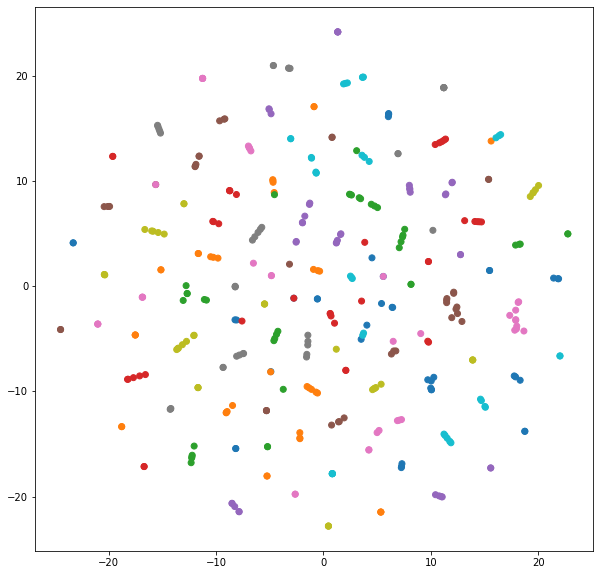

In [ ]:
# import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(Y_pred[:,0],Y_pred[:,1],c=y)

# plt.scatter(Y_pred[:,0], Y_pred[:,1], c = y, cmap = 'jet')
# plt.colorbar()
plt.show()